In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline

In [2]:
gpe = 100         # gridpoints in eccentricity
gps = 80          # gridpoints in size

sMin = -4    
sMax = 8

eMin = 0.0    
eMax = 0.2

size = np.linspace(sMin,sMax,gps)
eccs = np.linspace(eMin,eMax,gpe)

# if all results have same strength law, it is convenient to fill it in here

A_stg = 5e7      # strength constant A in erg g^-1
B_stg = 3.3e-8    # strength constant B
s_small = 0            # size_0 of strength eq = 1 cm in log cm
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

rho = 1
mass = np.log10(rho*1*np.pi/3) + 3*size  # log mass in g

asp_rat = (sMax-sMin)/(eMax-eMin)   # aspect ratio for plotting grid

G = 4*np.pi**2          # gravitational constant
sma = 45                # semimajor axis in au
h = 1                   # disk scale height h = 1 AU
mE = 5.972e27           # mass of Earth in g
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

def unpack(res, ge = gpe, gs = gps):
    N = np.load('%s/N.npy' %res)
    N_i = np.load('%s/N_i.npy' %res)
    N_o = np.load('%s/N_o.npy' %res)
    ts = np.load('%s/ts.npy' %res)
    dt = np.load('%s/dt.npy' %res)
    fu = np.load('%s/fu.npy' %res)

    steps_track = len(N)
    steps_integ = len(dt)
    print(res, 'took', steps_integ,'steps')
        
    N = N.reshape(steps_track,ge,gs)
    N_i = N_i.reshape(steps_track,ge,gs)
    N_o = N_o.reshape(steps_track,ge,gs)

    Ndot = 10**N_i - 10**N_o

    return N, N_i, N_o, Ndot, ts, dt, fu

def qstar(s1, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg, s0 = s_small):
    term1 = A * np.power(10,(s1-s0)*alp)
    term2 = B * rho * np.power(10,(s1-s0)*bet)
    return term1 + term2

def efault(s, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg):
    Q_ = qstar(s,A,B,alp,bet)/10000    # /10000 converts from cm^2/s^2 to m^2/s^2
    efail = np.sqrt(2*Q_)/vkep
    return efail

def mass_underline(numbers, A=A_stg, B=B_stg, alp=alp_stg, bet=bet_stg, step='all'):
    """
    Calculate total mass under the cricical line, below which it cannot be quickly destroyed
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        A, B, alp, bet -- floats; parameters of strength law used for this integration
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: mass_under -- float or array; total mass under the line at desired steps
    """
    efail = efault(size, A, B, alp, bet)  
    e_max = np.zeros(gps)
    mask = np.zeros((gpe,gps))
    
    # calculate max ecc bin at each size that is under this curve
    #   in our mask grid, set the cells under this one == 1
    
    cutoff = np.argmin(efail)
    for i in range(cutoff):
        e_max_it = np.argmin(abs(efail[i] - eccs))
        e_max[i] = e_max[i]
        
        mask[:e_max_it, i] = 1 
    
    if step == 'all':
        mass_under = np.zeros(len(numbers))
        for t in range(len(numbers)):
            num = 10**numbers[t]
            num_mask = num*mask
            mass_grid =  num_mask* 10**mass
            mass_under[t] = np.nansum(mass_grid)
            
    else:
        num = 10**numbers[step]
        num_mask = num*mask
        mass_grid =  num_mask* 10**mass
        mass_under = np.nansum(mass_grid)
            
    return mass_under

In [3]:
resdirlist1 = ['A_stg_2e7/results/e0-0.01_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.02_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.03_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.04_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.06_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.07_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.09_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10']

resdirlist2 = ['A_stg_5e7/results/e0-0.01_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.02_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.03_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.04_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.06_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.07_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.09_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.11_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.12_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.13_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.14_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.16_t-5.0Myr_m0-10Me_p-100_r-10']

resdirlist3 = ['A_stg_1e8/results/e0-0.01_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.02_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.03_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.04_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.06_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.07_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.09_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.11_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.12_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.13_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.14_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.16_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.17_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.18_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.19_t-5.0Myr_m0-10Me_p-100_r-10']

A2e7_e0 = np.linspace(0.01,0.10,10)
A5e7_e0 = np.linspace(0.01,0.16,16)
A1e8_e0 = np.linspace(0.01,0.19,19)

A2e7_mu = np.zeros(len(resdirlist1))
A5e7_mu = np.zeros(len(resdirlist2))
A1e8_mu = np.zeros(len(resdirlist3))

for i,d in enumerate(resdirlist1):
    N, _, _, _, _, _, _ = unpack(d)
    A2e7_mu[i] = mass_underline(N,A=2e7,step=-1)

for i,d in enumerate(resdirlist2):
    N, _, _, _, _, _, _ = unpack(d)
    A5e7_mu[i] = mass_underline(N,A=5e7,step=-1)

for i,d in enumerate(resdirlist3):
    N, _, _, _, _, _, _ = unpack(d)
    A1e8_mu[i] = mass_underline(N,A=1e8,step=-1)

A_stg_2e7/results/e0-0.01_t-5.0Myr_m0-10Me_p-100_r-10 took 12 steps
A_stg_2e7/results/e0-0.02_t-5.0Myr_m0-10Me_p-100_r-10 took 170 steps
A_stg_2e7/results/e0-0.03_t-5.0Myr_m0-10Me_p-100_r-10 took 396 steps
A_stg_2e7/results/e0-0.04_t-5.0Myr_m0-10Me_p-100_r-10 took 624 steps
A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 1226 steps
A_stg_2e7/results/e0-0.06_t-5.0Myr_m0-10Me_p-100_r-10 took 3765 steps
A_stg_2e7/results/e0-0.07_t-5.0Myr_m0-10Me_p-100_r-10 took 6565 steps
A_stg_2e7/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10 took 7372 steps
A_stg_2e7/results/e0-0.09_t-5.0Myr_m0-10Me_p-100_r-10 took 5359 steps
A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 4633 steps
A_stg_5e7/results/e0-0.01_t-5.0Myr_m0-10Me_p-100_r-10 took 8 steps
A_stg_5e7/results/e0-0.02_t-5.0Myr_m0-10Me_p-100_r-10 took 175 steps
A_stg_5e7/results/e0-0.03_t-5.0Myr_m0-10Me_p-100_r-10 took 370 steps
A_stg_5e7/results/e0-0.04_t-5.0Myr_m0-10Me_p-100_r-10 took 525 steps
A_stg_5e7/results/e0-0.05_t-5.0

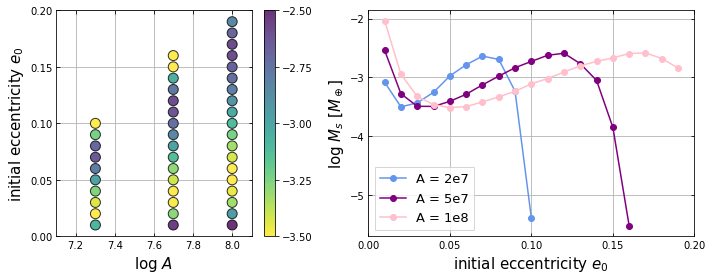

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'width_ratios': [1.5, 2]})

vmi = -3.5
vma = -2.5

a = ax[0].scatter(np.full(len(resdirlist1),np.log10(2e7)), A2e7_e0, 
            c='white',vmin=vmi,vmax=vma,s=100, zorder=5)
ax[0].scatter(np.full(len(resdirlist2),np.log10(5e7)), A5e7_e0,
            c='white',vmin=vmi,vmax=vma,s=100, zorder=5)
ax[0].scatter(np.full(len(resdirlist3),np.log10(1e8)), A1e8_e0,
            c='white',vmin=vmi,vmax=vma,s=100, zorder=5)

a = ax[0].scatter(np.full(len(resdirlist1),np.log10(2e7)), A2e7_e0, c=np.log10(A2e7_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100,alpha=.8, zorder=5)
ax[0].scatter(np.full(len(resdirlist2),np.log10(5e7)), A5e7_e0, c=np.log10(A5e7_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100,alpha=.8, zorder=5)
ax[0].scatter(np.full(len(resdirlist3),np.log10(1e8)), A1e8_e0, c=np.log10(A1e8_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100,alpha=.8, zorder=5)

cb = fig.colorbar(a,ticks=[-3.5,-3.25,-3,-2.75,-2.5],ax=ax[0])
ax[0].set_ylabel(r'initial eccentricity $e_0$',fontsize=15)
ax[0].set_xlabel(r'log $A$', fontsize=15)
ax[0].set_xlim(7.1,8.1)
ax[0].set_yticks([0,0.05,0.10,0.15,.20])
ax[0].set_ylim(0,.2)

for i in range(2):
    ax[i].tick_params(axis='both',direction='in',right=True,top=True)
    ax[i].grid(True,which='both',zorder=0)

ax[1].plot(A2e7_e0,np.log10(A2e7_mu/mE),marker='o',c='cornflowerblue')
ax[1].plot(A5e7_e0,np.log10(A5e7_mu/mE),marker='o',c='purple')
ax[1].plot(A1e8_e0,np.log10(A1e8_mu/mE),marker='o',c='pink')

ax[1].legend(['A = 2e7', 'A = 5e7', 'A = 1e8'],fontsize=13,fancybox=False)
ax[1].set_xlabel(r'initial eccentricity $e_0$', fontsize=15)
ax[1].set_ylabel(r'log $M_s$ [$M_\oplus$]',size=15)
ax[1].set_xlim(0,.20)
ax[1].set_xticks([0,0.05,0.10,0.15,0.20])
ax[1].set_yticks([-2,-3,-4,-5])

fig.tight_layout()
fig.savefig('strength_law_e0_dependence.png',dpi=300)

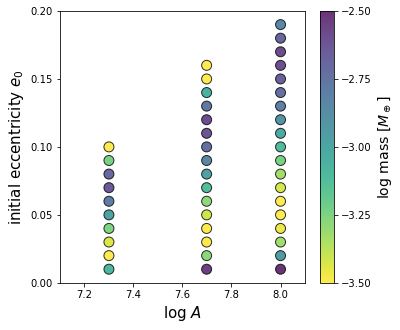

In [5]:
fig, ax = plt.subplots(figsize=(5.5,5))

vmi = -3.5
vma = -2.5

plt.scatter(np.full(len(resdirlist1),np.log10(2e7)), A2e7_e0, c=np.log10(A2e7_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100, alpha=.8)
plt.scatter(np.full(len(resdirlist2),np.log10(5e7)), A5e7_e0, c=np.log10(A5e7_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100,alpha=.8)
plt.scatter(np.full(len(resdirlist3),np.log10(1e8)), A1e8_e0, c=np.log10(A1e8_mu/mE),
            cmap='viridis_r',vmin=vmi,vmax=vma,edgecolor='k',s=100,alpha=.8)

cb = plt.colorbar(ticks=[-3.5,-3.25,-3,-2.75,-2.5])
cb.set_label(r'log $M_s$ [$M_\oplus$]',size=14)
ax.set_ylabel(r'initial eccentricity $e_0$',fontsize=15)
ax.set_xlabel(r'log $A$', fontsize=15)
ax.set_xlim(7.1,8.1)
ax.set_yticks([0,0.05,0.10,0.15,.20])
ax.set_ylim(0,.2)

plt.show()

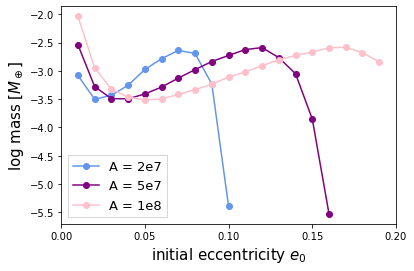

In [6]:
fig, ax = plt.subplots()

plt.plot(A2e7_e0,np.log10(A2e7_mu/mE),marker='o',c='cornflowerblue')
plt.plot(A5e7_e0,np.log10(A5e7_mu/mE),marker='o',c='purple')
plt.plot(A1e8_e0,np.log10(A1e8_mu/mE),marker='o',c='pink')

plt.legend(['A = 2e7', 'A = 5e7', 'A = 1e8'],fontsize=13,fancybox=False)
ax.set_xlabel(r'initial eccentricity $e_0$', fontsize=15)
ax.set_ylabel(r'log mass [$M_\oplus$]',fontsize=15)
ax.set_xlim(0,.20)
ax.set_xticks([0,0.05,0.10,0.15,0.20])
plt.show()